## Introduction

The purpose of this project is to predict the failure of a machine based on two of the features that exist in the dataset. The target column and the failure type column.

## Table of Contents



## Task and Data Description

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

## Reading and Analyzing Data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, r2_score, mean_squared_error, classification_report

In [2]:
df = pd.read_csv("data/predictive_maintenance.csv")

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [4]:
print(df["Target"].value_counts())
print(df["Failure Type"].value_counts())

0    9661
1     339
Name: Target, dtype: int64
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64


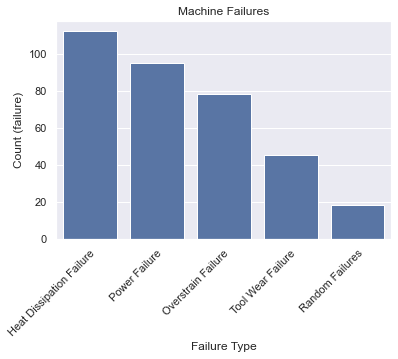

In [5]:
Fdf = df[df['Failure Type'] != 'No Failure']
Failure_type = Fdf['Failure Type'].value_counts(sort=True)

barplot1 = sns.barplot(x=Failure_type.index, y=Failure_type.values, color='b')
barplot1.set(xlabel="Failure Type", ylabel="Count (failure)", title="Machine Failures")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor");


## Preprocessing Data

The first problem we have, right off the bat, is that the counts in the target column do not match the failure types indicated in the second target column. So we have to (1) remove any row that indicates a 1 in the target column and no failure in the failure type column and (2) remove any row that indicates a 0 in the target column but indicates a failure type in the type column.

In [6]:
dfdrop1 = ((df['Target'] == 0) & (df["Failure Type"] != 'No Failure')) | ((df['Target'] == 1) & (df["Failure Type"] == 'No Failure'))
df1 = df[~dfdrop1]
df1

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


We shopuld also convert all the integer columns to floats to prep them for the modeling process

In [7]:
df1 = df1.astype({"Rotational speed [rpm]":'float', "Tool wear [min]":'float', "Target":'float'}) 

Lets just double check for nulls in trhe dataset

In [8]:
df1.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Great none to be had. Lets convert the categorical columns to numeric for type and failure type.

In [9]:
from sklearn.preprocessing import LabelEncoder

df2 = df1.copy()

le = LabelEncoder()
le.fit(df2['Failure Type'].drop_duplicates()) 
df2['Failure Type'] = le.transform(df2['Failure Type'])

one_hot_type = pd.get_dummies(df2['Type'])
df3 = df2.join(one_hot_type)

df3.drop(['UDI', 'Product ID', 'Type'], axis=1, inplace=True)
df3.head()


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,H,L,M
0,298.1,308.6,1551.0,42.8,0.0,0.0,1,0,0,1
1,298.2,308.7,1408.0,46.3,3.0,0.0,1,0,1,0
2,298.1,308.5,1498.0,49.4,5.0,0.0,1,0,1,0
3,298.2,308.6,1433.0,39.5,7.0,0.0,1,0,1,0
4,298.2,308.7,1408.0,40.0,9.0,0.0,1,0,1,0


Now that all of the columns are cleaned, we want to plot them and see how the data looks in comparison to the failures that have been happening. Hopefully we can identify which columns are the culprits in the failures.

In [10]:
#Create a color palette for each of the categories, to keep the colors consistent when No Failure is dropped from plots
palette = {'No Failure':"tab:blue", #blue blue
           'Power Failure':"#e17701", #pumpkin orange
           'Tool Wear Failure':"#89a203", #vomit green
           'Overstrain Failure':"#a00498", #barney
           'Heat Dissipation Failure':"#e50000"} #red

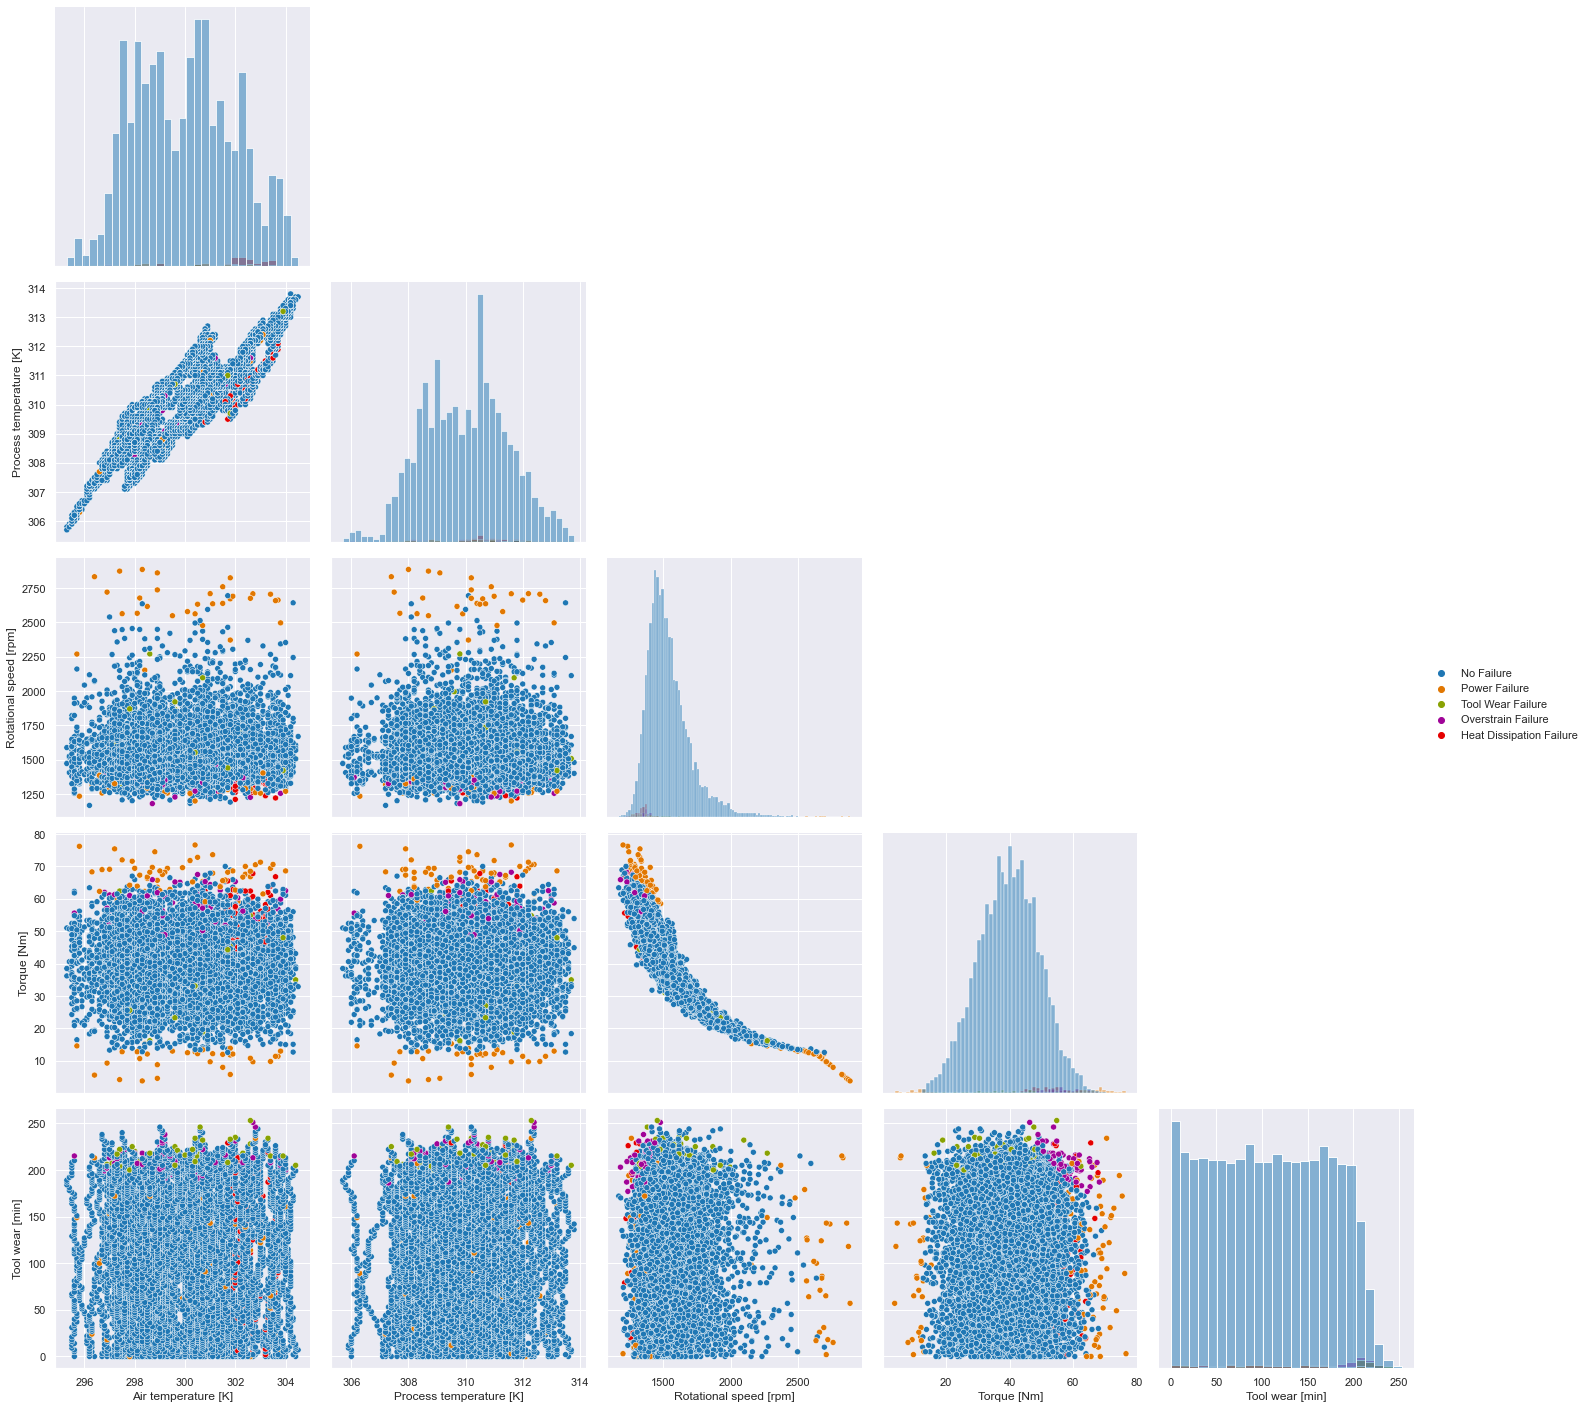

In [11]:
#plot all columns with each failure as a different color
df1plot1 = df1.drop(['UDI', 'Product ID', 'Target'], axis=1)

g = sns.PairGrid(df1plot1, hue="Failure Type", palette=palette, height=4, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend(title="", );

It doesnt look like the process temperature and air temperature have much bearing on the failure of the machine. Lets remove the data points that are not considered failures to get a better look.

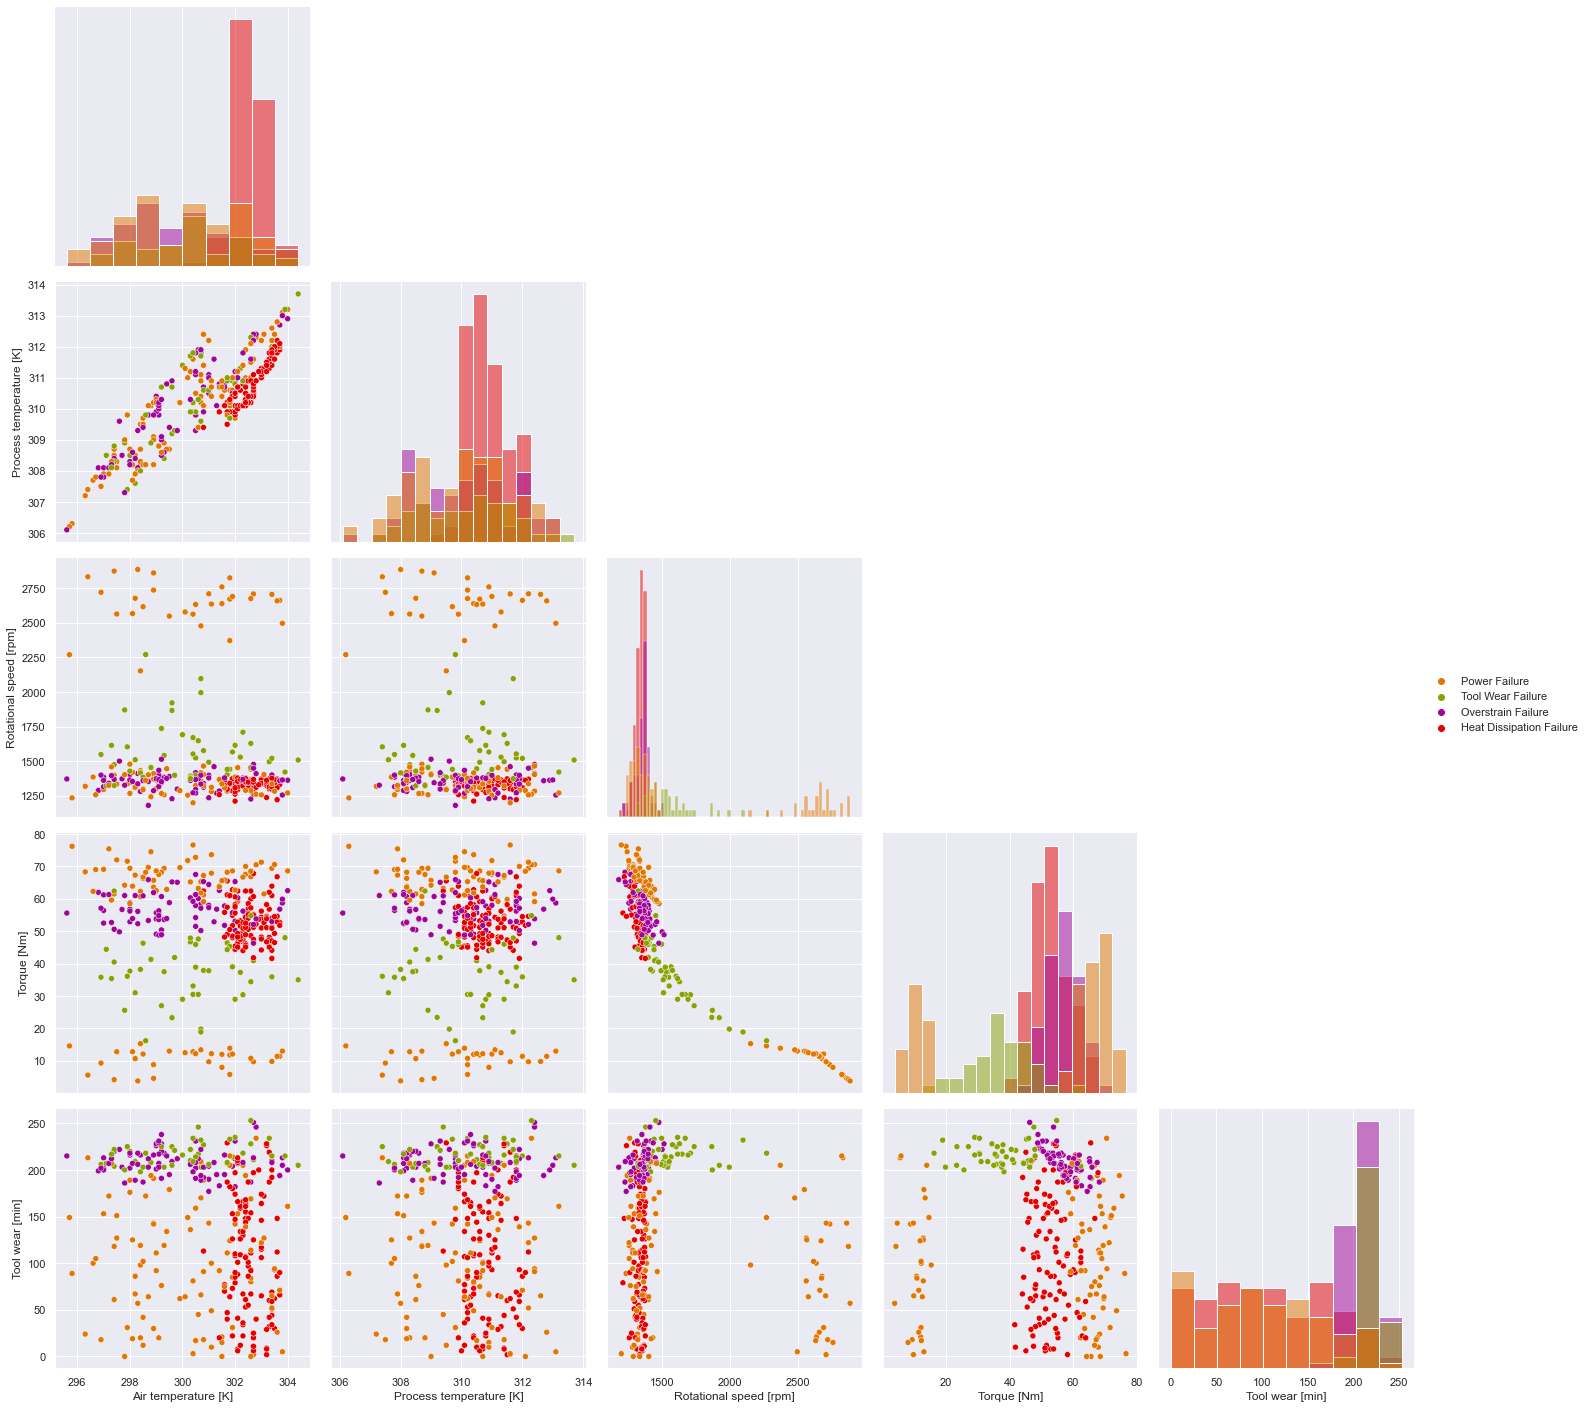

In [12]:
df1plot2 = df1plot1[df1plot1['Failure Type'] != 'No Failure']

g = sns.PairGrid(df1plot2, hue="Failure Type", palette=palette, height=4, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend(title="", );

Process temperature is normally distributed and from looking at the scatterplots (even though it has some relationship to heat dissipation failure) it really does not need to be included in the model going forward. The Air temperature does have a correlation to Heat dissipation BUT considering this machine is not meant to cut parts and not heat anything to bake, cook, or cure parts, the air temperature alone cannot be causing the failure. It is only an indication for the failure. Looking in the rotational speed column, we can see that this feature is definitinely responsible for the heat dissipation failures when the rotational speeds are running low.

Considering all of this, we will take out the process temperature and air temperature from our dataframe and plot them again

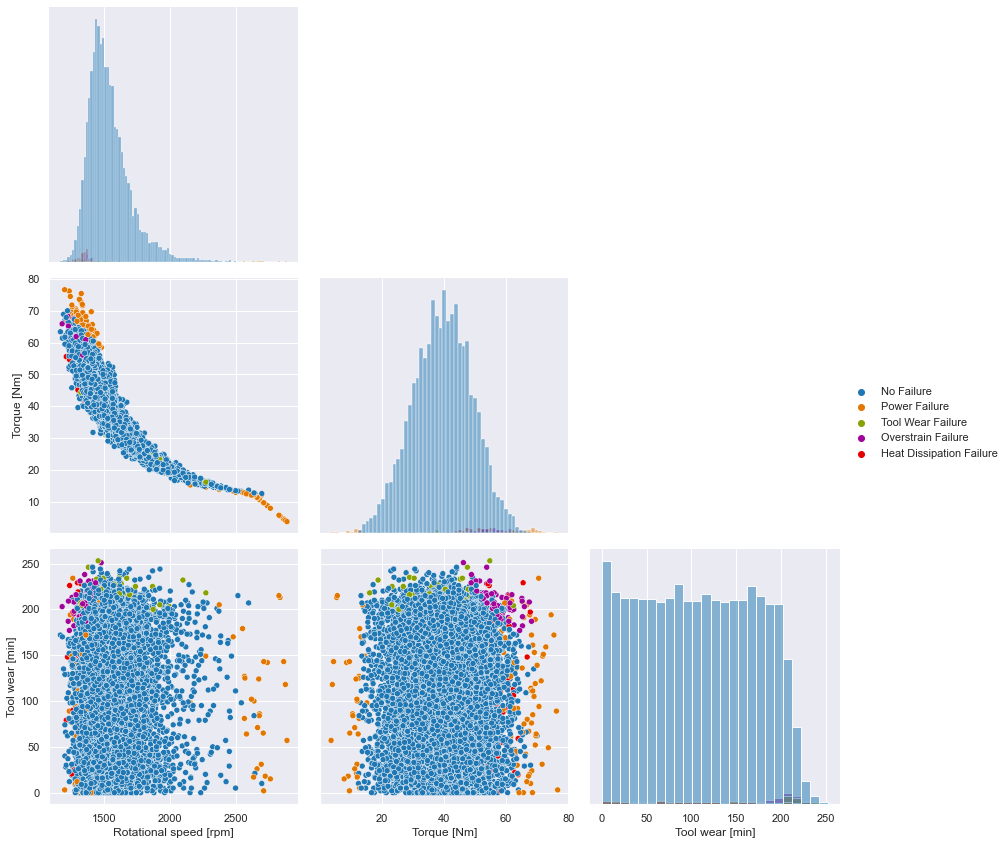

In [13]:
df1plot3 = df1.drop(['UDI', 'Product ID', 'Target', 'Process temperature [K]', 'Air temperature [K]'], axis=1)

g = sns.PairGrid(df1plot3, hue="Failure Type", palette=palette, height=4, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend(title="", );

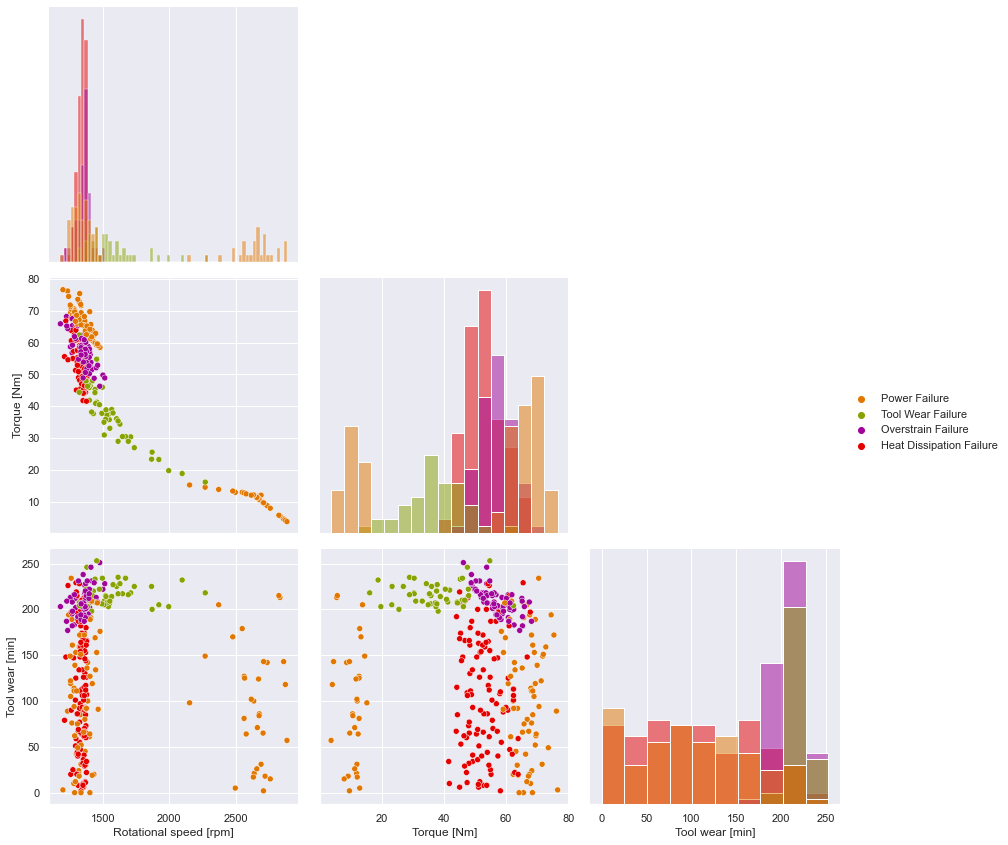

In [14]:
df1plot4 = df1plot3[df1plot3['Failure Type'] != 'No Failure']
g = sns.PairGrid(df1plot4, hue="Failure Type", palette=palette, height=4, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend(title="", );

## Preparing the Data for Modeling

We will take the data now, remove the unnecessary columns, and split the data into test and train sets

In [56]:
df3

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,H,L,M
0,298.1,308.6,1551.0,42.8,0.0,0.0,1,0,0,1
1,298.2,308.7,1408.0,46.3,3.0,0.0,1,0,1,0
2,298.1,308.5,1498.0,49.4,5.0,0.0,1,0,1,0
3,298.2,308.6,1433.0,39.5,7.0,0.0,1,0,1,0
4,298.2,308.7,1408.0,40.0,9.0,0.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604.0,29.5,14.0,0.0,1,0,0,1
9996,298.9,308.4,1632.0,31.8,17.0,0.0,1,1,0,0
9997,299.0,308.6,1645.0,33.4,22.0,0.0,1,0,0,1
9998,299.0,308.7,1408.0,48.5,25.0,0.0,1,1,0,0


In [58]:
X = df3.drop(['Failure Type', 'Target'], axis=1)
y = df3['Failure Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [83]:
scaler = StandardScaler()

scaler.fit(X_train)

# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

In [84]:
clf = KNeighborsClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Perform cross-validation
knn_baseline_log_loss = - cross_val_score(clf, X_train_scaled, y_train, scoring="neg_log_loss")

print("Baseline F1 score: {}".format(f1_score(y_test, y_pred, average='weighted')))
print("Baseline Log loss: {}".format(knn_baseline_log_loss.mean()))

Baseline F1 score: 0.9556627827008085
Baseline Log loss: 0.5909644557296174


In [85]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=40):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average='weighted')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [86]:
find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

Best Value for k: 5
F1-Score: 0.9556627827008085


In [87]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Perform cross-validation
knn_first_log_loss = - cross_val_score(clf, X_train_scaled, y_train, scoring="neg_log_loss")

print("Model F1 score: {}".format(f1_score(y_test, y_pred, average='weighted')))
print("Model Log loss: {}".format(knn_first_log_loss.mean()))

Model F1 score: 0.9556627827008085
Model Log loss: 0.5909644557296174


In [88]:
print("accuracy: ", accuracy_score(y_test, y_pred))
print("Classification_Report: \n", classification_report(y_test, y_pred))

accuracy:  0.9687249398556536
Classification_Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.97      1.00      0.98      2411
           2       0.75      0.15      0.25        20
           3       1.00      0.12      0.22        24
           4       0.00      0.00      0.00        11

    accuracy                           0.97      2494
   macro avg       0.54      0.25      0.29      2494
weighted avg       0.95      0.97      0.96      2494



C:\Users\Tim\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = mean_squared_error(y_true, y_predict, squared=False)

    # If using an older version of sklearn:
    # rmse = np.sqrt(mean_squared_error(y_true, y_predict))

    # Return the score
    return [r2, rmse]


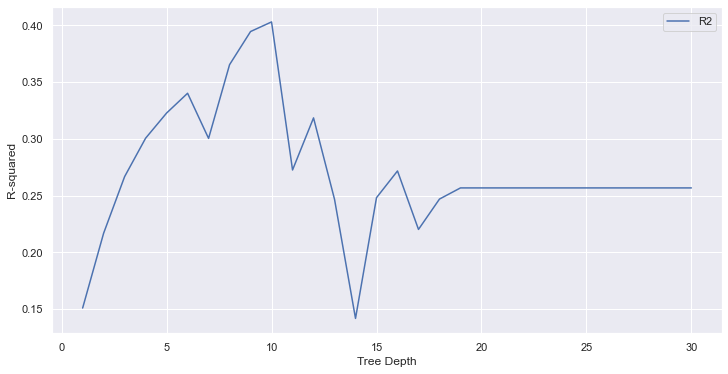

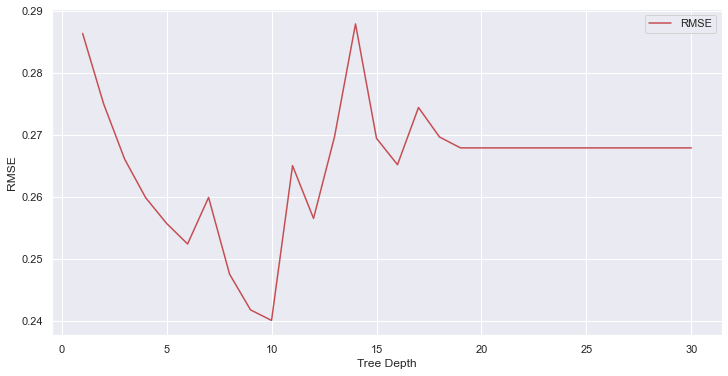

In [90]:
max_depths = list(range(1, 31))
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, 
                                      random_state=45)
    regressor.fit(X_train_scaled, y_train)
    y_pred = regressor.predict(X_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(max_depths, mse_results, 'r', label='RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [93]:
clf2 = DecisionTreeClassifier()

regressor = DecisionTreeRegressor(random_state=45)
regressor.fit(X_train_scaled, y_train)
y_pred_DT = regressor.predict(X_test)

dt_baseline_log_loss = - cross_val_score(clf2, X_train_scaled, y_train, scoring="neg_log_loss")

dt_baseline_log_loss

array([1.03893378, 0.78497219, 0.96967153, 0.6695351 , 0.94721728])

In [94]:
dt_baseline_log_loss.mean()

0.8820659770998708

In [95]:
regressor = DecisionTreeRegressor(random_state=45, max_depth=10)
regressor.fit(X_train_scaled, y_train)
y_pred_DT1 = regressor.predict(X_test)

dt_first_log_loss = - cross_val_score(clf2, X_train_scaled, y_train, scoring="neg_log_loss")

dt_first_log_loss

array([0.94658411, 0.73879736, 1.0620212 , 0.71570994, 0.92411442])

In [96]:
dt_first_log_loss.mean()

0.8774454050069063

In [101]:
# print("accuracy: ", accuracy_score(y_test, y_pred_DT1))
print("Classification_Report: \n", classification_report(y_test, y_pred_DT1))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [137]:
final_model = KNeighborsClassifier(n_neighbors=7, weights='distance')

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [138]:
preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

# print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

accuracy:  0.9783480352846833
precision: 0.8536585365853658
recall:    0.42168674698795183
